## DataLoaders requirements:

* Use X and y
* In memory or on disk np.arrays
* Use item tfms and/ or batch tfms
* Show batch (with tfms)
* Good performance
* Slice the dataset 
* Pass batch tfms

In [1]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [3]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [4]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

In [5]:
def cycle_dl(dl):
    for x,y in iter(dl): pass

In [6]:
if not os.path.exists('../data'): os.makedirs('../data')
    
X_1000_2_10_in_memory = np.random.rand(1000, 2, 10).astype('float32')
np.save('../data/X_1000_2_10.npy', X_1000_2_10_in_memory)
X_1000_2_10_on_disk = np.load('../data/X_1000_2_10.npy', mmap_mode='r')

X_1000_20_100_in_memory = np.random.rand(1000, 20, 100).astype('float32')
np.save('../data/X_1000_20_100.npy', X_1000_20_100_in_memory)
X_1000_20_100_on_disk = np.load('../data/X_1000_20_100.npy', mmap_mode='r')

X_1000_200_10_in_memory = np.random.rand(1000, 200, 10).astype('float32')
np.save('../data/X_1000_200_10.npy', X_1000_200_10_in_memory)
X_1000_200_10_on_disk = np.load('../data/X_1000_200_10.npy', mmap_mode='r')

X_1000_2_1000_in_memory = np.random.rand(1000, 2, 1000).astype('float32')
np.save('../data/X_1000_2_1000.npy', X_1000_2_1000_in_memory)
X_1000_2_1000_on_disk = np.load('../data/X_1000_2_1000.npy', mmap_mode='r')

X_100_20_1000_in_memory = np.random.rand(100, 20, 1000).astype('float32')
np.save('../data/X_100_20_1000.npy', X_100_20_1000_in_memory)
X_100_20_1000_on_disk = np.load('../data/X_100_20_1000.npy', mmap_mode='r')

X_1000_20_1000_in_memory = np.random.rand(1000, 20, 1000).astype('float32')
np.save('../data/X_1000_20_1000.npy', X_1000_2_1000_in_memory)
X_1000_20_1000_on_disk = np.load('../data/X_1000_20_1000.npy', mmap_mode='r')

X_10000_2_10_in_memory = np.random.rand(10000, 2, 10).astype('float32')
np.save('../data/X_10000_2_10.npy', X_10000_2_10_in_memory)
X_10000_2_10_on_disk = np.load('../data/X_10000_2_10.npy', mmap_mode='r')

# StarLight valid like
X_1000_1_1024_in_memory = np.random.rand(1000, 1, 1024).astype('float32')
np.save('../data/X_1000_1_1024.npy', X_1000_1_1024_in_memory)
X_1000_1_1024_on_disk = np.load('../data/X_1000_1_1024.npy', mmap_mode='r')

X_8236_1_1024_in_memory = np.random.rand(8236, 1, 1024).astype('float32')
np.save('../data/X_8236_1_1024.npy', X_8236_1_1024_in_memory)
X_8236_1_1024_on_disk = np.load('../data/X_8236_1_1024.npy', mmap_mode='r')

X_starlight_in_memory = concat(X_1000_1_1024_in_memory, X_8236_1_1024_in_memory)
np.save('../data/X_starlight.npy', X_starlight_in_memory)
X_starlight_on_disk = np.load('../data/X_starlight.npy', mmap_mode='r')
splits = (L(list(np.arange(len(X_1000_1_1024_in_memory)))), 
          L(list(np.arange(len(X_1000_1_1024_in_memory), len(X_starlight_in_memory)))))

y_100 = np.random.randint(0, 10, 100)
y_1000 = np.random.randint(0, 10, 1000)
y_10000 = np.random.randint(0, 10, 10000)
y_8236 = np.random.randint(0, 10, 8236)
y_starlight = concat(y_1000, y_8236)

Xs_in_memory = [X_1000_20_100_in_memory, X_1000_200_10_in_memory, X_1000_2_1000_in_memory, 
               X_100_20_1000_in_memory, X_1000_20_1000_in_memory, X_10000_2_10_in_memory, X_8236_1_1024_in_memory]
Xs_on_disk = [X_1000_20_100_on_disk, X_1000_200_10_on_disk, X_1000_2_1000_on_disk, 
               X_100_20_1000_on_disk, X_1000_20_1000_on_disk, X_10000_2_10_on_disk, X_8236_1_1024_on_disk]
ys = [y_1000, y_1000, y_1000, y_100, y_1000, y_10000, y_8236]

### Native Pytorch dataloader

In [7]:
# Native Pytorch
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, sel_vars=None, sel_steps=None):
        self.X, self.y = X, y
        self.sel_vars =  slice(None) if sel_vars is None else sel_vars
        self.sel_steps =  slice(None) if sel_steps is None else sel_steps

    def __getitem__(self, idx):
        return (self.X[idx, self.sel_vars, self.sel_steps], ) if self.y is None \
        else (self.X[idx, self.sel_vars, self.sel_steps], self.y[idx])

    def __len__(self):
        return len(self.X)

In [8]:
for x_, y_ in zip(Xs_in_memory, ys):
    ds    = NumpyDataset(x_, y_)
    dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=128)
    print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}')
    %timeit cycle_dl(dl)
    print()

shape: (1000, 20, 100)        numel:    2,000,000
40.8 ms ± 7.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (1000, 200, 10)        numel:    2,000,000
34.8 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (1000, 2, 1000)        numel:    2,000,000
33.3 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (100, 20, 1000)        numel:    2,000,000
8.49 ms ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

shape: (1000, 20, 1000)       numel:   20,000,000
79 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

shape: (10000, 2, 10)         numel:      200,000
340 ms ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

shape: (8236, 1, 1024)        numel:    8,433,664
247 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [9]:
# test larger batch size
x_ = X_8236_1_1024_in_memory
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

ds    = NumpyDataset(x_, y_)
dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=1280)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
280 ms ± 51.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 1280
275 ms ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



**Key learning:** 

The number of dimensions or length of the time series doesn't have a significant impact on dataloader's performance. 

Performance is mostly determined by the number of samples, not the number of batches.

Pytorch native dataloader is pretty fast, although it misses these 3 requirements: 

* In memory or on disk np.arrays
* Use item tfms and/ or batch tfms
* Show batch (with tfms)

I'll modify the default_collate to allow np.memmap as well. This shouldn't have any impact on performance.

In [ ]:
def dataloader(dataset,
               batch_size=1,
               shuffle=False,
               sampler=None,
               batch_sampler=None,
               num_workers=0,
               collate_fn=np_collate,
               pin_memory=False,
               drop_last=False,
               timeout=0,
               worker_init_fn=None,
               multiprocessing_context=None):

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn,
        multiprocessing_context=multiprocessing_context)


NumpyDataset.dataloader = dataloader

In [ ]:
# test in memory vs on disk arrays
x_ = X_8236_1_1024_in_memory
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = torch.utils.data.DataLoader(dataset=ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

x_ = X_8236_1_1024_in_memory
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

x_ = X_8236_1_1024_on_disk
y_ = y_8236
ds    = NumpyDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

**Key learnings:**

- The updated collate function (that allows memmap conversion into a tensor) doesn't negetively impact performance when used with np.ndarrays

- data is on disk is 40% slower than in memory, so it's better to pass data in memory if possible. However, performance is still good with data on disk.


So we can now meet 3 of the requirements, but cannot still use tfms or show_batch.

In [ ]:
#conversion to TS tensor
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y
        
    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (TSTensor(self.X[idx]), self.y[idx])

    def __len__(self):
        return len(self.X)
    
TSDataset.dataloader = dataloader

In [ ]:
# Prior conversion to TSTensor
x_ = X_8236_1_1024_on_disk
y_ = y_8236

ds    = NumpyDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

ds    = TSDataset(x_, y_)
dl    = ds.dataloader(batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dl)
print()

Conversion to TSTensor makes it is 30-40% slower, so it doesn't seem useful.

### Factory method

In [ ]:
x_ = X_starlight_in_memory
y_ = y_starlight
dls = TSDataLoaders.from_numpy(x_, y_, splitter=IndexSplitter(splits[1]), bs=64, val_bs=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

### Datablock

In [ ]:
x_ = X_starlight_in_memory
y_ = y_starlight
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(x_, y_)
dls = dblock.dataloaders(source, bs=64, val_bs=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

### Datasets + DataLoaders

In [ ]:
class NumpyDatasets(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
        super().__init__(dl_type=dl_type)

        #New 4 lines of code
        if tls is None:
            if items is None: items = itemify(X,) if y is None else itemify(X,y)
            assert (tfms is None or len(items[0]) == len(tfms)), f"n_tfms ({len(tfms)}) doesn't match n_items ({len(items[0])})"
            tfms = None if tfms is None else [[ItemGetter(i)] + L(tfms[i]) for i in range(len(items[0]))]
        
        self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

    def __getitem__(self, it):
        res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))

    def __getattr__(self,k): return gather_attrs(self, k, 'tls')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
    def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    def overlapping_splits(self): return self.tls[0].overlapping_splits()
    @property
    def splits(self): return self.tls[0].splits
    @property
    def split_idx(self): return self.tls[0].tfms.split_idx
    @property
    def items(self): return self.tls[0].items
    @items.setter
    def items(self, v):
        for tl in self.tls: tl.items = v

    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    def new_empty(self):
        tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
        return type(self)(tls=tls, n_inp=self.n_inp)

    @contextmanager
    def set_split_idx(self, i):
        old_split_idx = self.split_idx
        for tl in self.tls: tl.tfms.split_idx = i
        yield self
        for tl in self.tls: tl.tfms.split_idx = old_split_idx

In [ ]:
x_ = X_starlight_in_memory
y_ = y_starlight

tfms  = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(x_, y_, tfms=tfms, splits=splits)
dls   = DataLoaders.from_dsets(dsets.train, dsets.valid, bs=32, val_bs=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

**Key insights:**

- Both factory method, datablock API and NumpyDatasets + DataLoaders are all very slow compared to native Pytorch.
- Fastai misses these requirements:

    * In memory or on disk np.arrays
    * Good performance

### Hybrid approach

This approach was suggested by Sylvain Gugger [here](https://forums.fast.ai/t/datablock-with-numpy-input/64848/2?u=oguiza):


"You can create a DataLoaders object from regular PyTorch datasets (though all the visualization methods like show_batch and show_results will fail)."

In [ ]:
x_ = X_1000_1_1024_in_memory
y_ = y_1000
train_ds = NumpyDataset(x_, y_)

x_ = X_8236_1_1024_in_memory
y_ = y_8236
valid_ds = NumpyDataset(x_, y_)
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

In [12]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, sel_vars=None, sel_steps=None):
        self.X, self.y = X, y
        self.sel_vars =  slice(None) if sel_vars is None else sel_vars
        self.sel_steps =  slice(None) if sel_steps is None else sel_steps

    def __getitem__(self, idx):
        return (TSTensor(self.X[idx, self.sel_vars, self.sel_steps], )) if self.y is None \
        else (TSTensor(self.X[idx, self.sel_vars, self.sel_steps]), self.y[idx])

    def __len__(self):
        return len(self.X)

In [ ]:
x_ = X_1000_1_1024_on_disk
y_ = y_1000
train_ds = TSDataset(x_, y_)

x_ = X_8236_1_1024_on_disk
y_ = y_8236
valid_ds = TSDataset(x_, y_)
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

This approach is certainly much faster than the default fastai v2. 

TSDataset has the additional benefit that allows you to use data on disk.

However, it's still much slower than Pytorch dl.

In [10]:
x_ = X_1000_1_1024_in_memory
y_ = y_1000

train_ds = NumpyDataset(x_, y_)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)

x_ = X_8236_1_1024_in_memory
y_ = y_8236

valid_ds = NumpyDataset(x_, y_)
valid_dl = DataLoader(valid_ds, bs=128)

dls   = DataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
367 ms ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is **very fast**, but it has at least a couple problems: 

* it doesn't allow us to use show_batch. 
* it doesn't allow us to pass an array on disk

Let's see how if we can fix that.

In [14]:
class FloatTensor(TensorBase):
    '''Returns a tensor of type float.int32 and class IntTensor'''
    def __new__(cls, o, dtype=torch.float32, **kwargs): 
        res = tensor(o, dtype=dtype)
        res.__class__ = cls
        res._meta = kwargs
        return res
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim == 0: return str(self.item())
        else: return f'IntTensor(len:{len(self)})'

    def show(self, ax=None, ctx=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(self, weight='bold')
        plt.tight_layout()
        return ax

class IntTensor(TensorBase):
    '''Returns a tensor of type torch.int64 and class IntTensor'''
    def __new__(cls, o, dtype=torch.int64, **kwargs): 
        res = tensor(o, dtype=dtype)
        res.__class__ = cls
        res._meta = kwargs
        return res
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim == 0: return str(self.item())
        else: return f'IntTensor(len:{len(self)})'

    def show(self, ax=None, ctx=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(self, weight='bold')
        plt.tight_layout()
        return ax


class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, y_class=IntTensor, sel_vars=None, sel_steps=None):
        self.X, self.y = X, y
        self.y_class = y_class
        self.sel_vars =  slice(None) if sel_vars is None else sel_vars
        self.sel_steps =  slice(None) if sel_steps is None else sel_steps
        
    def __getitem__(self, idx):
        if self.y is None:  return (TSTensor(self.X[idx, self.sel_vars, self.sel_steps]), )
        else:  return (TSTensor(self.X[idx, self.sel_vars, self.sel_steps]), self.y_class(self.y[idx]))

    def __len__(self):
        return len(self.X)

    def __len__(self):
        return len(self.X)

    
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
        b = L(zip(*b))
        if nrows is None: 
            sqrt = math.sqrt(len(b))
            rows = min(math.ceil(sqrt), len(b)) 
        if ncols is None: ncols = len(b) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(b[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(tup, ax=ax)
        plt.tight_layout()

In [15]:
x_ = X_1000_1_1024_on_disk
y_ = y_1000

train_ds = TSDataset(x_, y_, y_class=IntTensor)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, drop_last=True)

x_ = X_8236_1_1024_on_disk
y_ = y_8236

valid_ds = TSDataset(x_, y_, y_class=IntTensor)
valid_dl = DataLoader(valid_ds, bs=128)

dls   = TSDataLoaders(train_dl, valid_dl)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(x_.shape):20}   numel: {len(x_.ravel()):12,}   bs: {len(xb)}')
%timeit cycle_dl(dls.valid)

shape: (8236, 1, 1024)        numel:    8,433,664   bs: 128
1.19 s ± 158 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


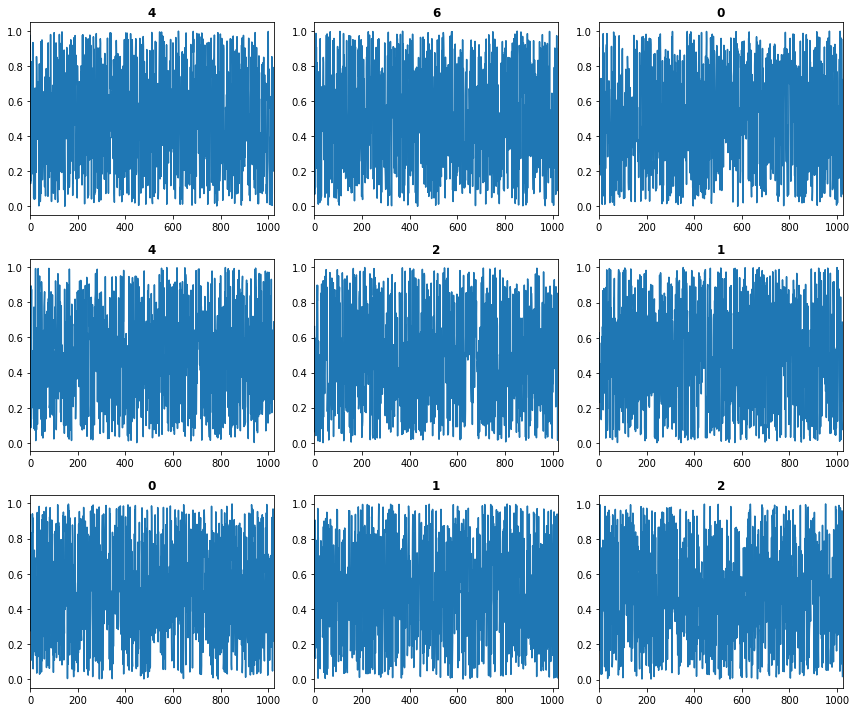

In [16]:
dls.show_batch()